In [1]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [3]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512,512)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
!pwd

/home/ubuntu/lialib/colab


In [6]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [7]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [8]:
class_order

tensor([30, 43, 94, 73, 34, 67, 62, 33, 61, 15, 78, 28, 41, 68, 57,  0,  3, 22,
         5,  2, 65, 26, 54, 32, 24, 83, 72, 13, 29, 49, 98, 20, 31, 82, 71, 44,
        42, 91, 40, 99, 23, 97,  6, 90, 45, 63, 60, 56, 87, 47, 79, 51, 58, 17,
        16, 96, 52, 75, 92, 69, 35, 38, 53, 25,  1, 80, 39, 88, 21, 74, 36, 19,
        11, 10, 76, 89, 59, 37,  9, 14, 81, 95, 77, 64, 70, 46, 55, 66, 86, 85,
        18, 12,  7, 48, 93,  4, 27,  8, 50, 84])

In [11]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [12]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [14]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [15]:
set_test.shape

(5000,)

In [16]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [17]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [18]:
x,y = next(iter(dl_train))

In [19]:
y.shape

torch.Size([64])

In [20]:
y

tensor([91, 30, 68, 34, 83, 83, 24, 83, 56, 42, 30, 29, 34, 49, 47, 45, 99,  0,
        72, 41, 22, 43, 54, 45,  2,  2, 62,  3, 15,  5, 68, 47,  0, 44, 73, 62,
        78,  5, 98, 71,  6, 56, 47, 82, 98, 63, 56, 60, 97, 34,  0, 44, 28, 65,
        22, 73, 63,  2,  3, 99, 68,  2, 71,  0])

In [21]:
from pytorch_metric_learning import losses
loss_func = losses.ArcFaceLoss(num_classes=100,embedding_size=512)


In [22]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [23]:
import wandb

In [24]:
wandb.init(
    # set the wandb project where this run will be logged
    project="clip+dmil",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edson-matsubara (lablia). Use `wandb login --relogin` to force relogin


In [26]:

opt = optim.Adam(model.parameters(),lr=0.001)

In [27]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [28]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
emb_batch = model(x.to(device))

In [58]:
from sklearn.manifold import TSNE

In [64]:
# given a batch of instances create a surrounding sample of instances
def create_surrounding_batch(batch,batch_y, num_surrounding=100, size=0.001):
    surrounding_batch = []
    surrounding_batch_y = []
    for i in range(len(batch)):
        
        instances_sorrounding = batch[i]+(torch.randn(num_surrounding,512)*size).to(batch.device)
        surrounding_batch.append(instances_sorrounding)
        surrounding_batch_y.append(batch_y[i].repeat(num_surrounding))
    return torch.cat(surrounding_batch), torch.cat(surrounding_batch_y)

In [65]:
batch_emb, batch_y = create_surrounding_batch(emb_batch,y)

In [66]:
batch_emb.shape

torch.Size([6400, 512])

In [67]:
batch_y.shape

torch.Size([6400])

In [71]:

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...
[t-SNE] Computed neighbors for 6400 samples in 0.643s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.150047
[t-SNE] KL divergence after 1000 iterations: 0.934617


In [48]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [74]:
def tsne_proj(batch_emb, batch_y):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())
    cmap = cm.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(15,15))
    num_categories = 100
    for lab in range(num_categories):
        if lab in batch_y:
            indices = batch_y==lab
            ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...
[t-SNE] Computed neighbors for 6400 samples in 0.669s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.139992
[t-SNE] KL divergence after 1000 iterations: 0.934058


/tmp/ipykernel_5295/3286734825.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


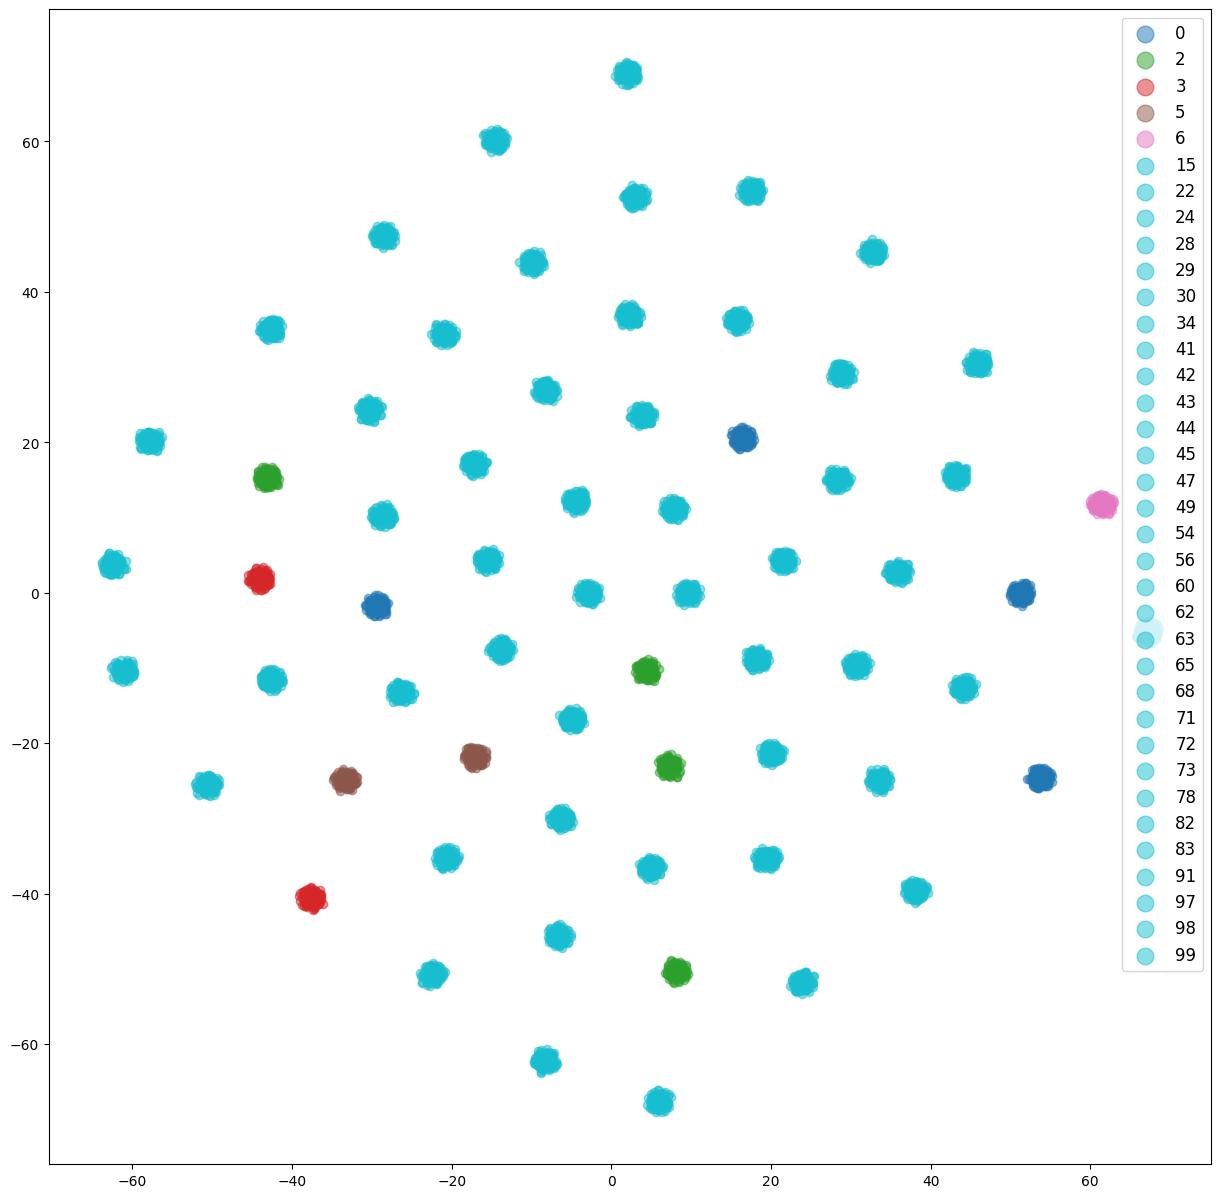

In [75]:
tsne_proj(batch_emb,batch_y)

In [76]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [77]:
import sklearn.neighbors as neighbors

In [78]:
from sklearn.metrics import classification_report

In [79]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=1,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [80]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

100%|██████████| 5/5 [00:00<00:00, 127.84it/s]


In [81]:
pred.shape,test_y.T.shape

((300,), (300,))

In [82]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       0.06      0.33      0.10         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         3
          20       0.14      0.09      0.11        11
          22       0.00      0.00      0.00         7
          23       0.00      0.00      0.00         8
          24       0.00      0.00      0.00         4
          26       0.00      0.00      0.00         8
          28       0.00      0.00      0.00         2
          29       0.00      0.00      0.00         3
          30       0.00      0.00      0.00         7
          31       0.00      0.00      0.00         8
          32       0.00      0.00      0.00         6
          33       0.17    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        batch_emb, batch_y = create_surrounding_batch(embeddings,labels)
        loss = loss_func(batch_emb, batch_y)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)
        print(classification_report(test_y.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.37it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           5       0.25      0.12      0.17         8
           7       0.00      0.00      0.00         7
           8       0.06      0.17      0.08         6
           9       1.00      0.40      0.57         5
          10       0.25      0.20      0.22         5
          14       0.00      0.00      0.00         2
          16       0.14      0.10      0.12        10
          20       0.00      0.00      0.00         4
          21       0.25      0.29      0.27         7
          22       0.00      0.00      0.00         9
          25       0.50      0.20      0.29         5
          30       0.33      0.29      0.31         7
          31       0.00      0.00      0.00        10
          32       0.00      0.00      0.00         3
          33       0.12      0.14      0.13         7
          34       0.14      0.40      0.21         5
          35       0.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


31.019898787788723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.63it/s]


29.935821938087873


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


28.62053679444296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:50<00:00,  7.68it/s]


27.120988748262604


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.60it/s]


25.421004849016818


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.50it/s]


23.671112797144428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


21.953275646395085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


20.022183298759753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.38it/s]


18.08702154232718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           5       0.62      0.62      0.62         8
           7       0.57      0.57      0.57         7
           8       1.00      1.00      1.00         6
           9       1.00      0.80      0.89         5
          10       0.44      0.80      0.57         5
          14       0.00      0.00      0.00         2
          16       1.00      0.60      0.75        10
          20       0.67      1.00      0.80         4
          21       0.50      0.57      0.53         7
          22       0.75      0.67      0.71         9
          25       0.20      0.20      0.20         5
          30       0.83      0.71      0.77         7
          31       0.80      0.40      0.53        10
          32       0.00      0.00      0.00         3
          33       0.14      0.43      0.21         7
          34       0.43      0.60      0.50         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


13.437952836761085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


10.454065650930184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


7.612692526844151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.38it/s]


4.822003871888456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.51it/s]


2.793253205049678


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.56it/s]


1.755534179156165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.45it/s]


1.1299871373207062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.60it/s]


0.9332857975817245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.51it/s]


0.8325563215012269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.17it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           5       0.38      0.62      0.48         8
           7       1.00      0.71      0.83         7
           8       1.00      1.00      1.00         6
           9       0.83      1.00      0.91         5
          10       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         2
          16       1.00      0.50      0.67        10
          20       0.57      1.00      0.73         4
          21       0.60      0.43      0.50         7
          22       0.60      0.67      0.63         9
          25       0.40      0.40      0.40         5
          30       0.75      0.86      0.80         7
          31       1.00      0.60      0.75        10
          32       1.00      0.67      0.80         3
          33       0.14      0.57      0.23         7
          34       0.80      0.80      0.80         5
          35       0.33    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.7518772025964201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.7088958141904579


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.53it/s]


0.7337500331310026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.45it/s]


0.6785653142831883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.5931627893539005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.43it/s]


0.5417063843685409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.49it/s]


0.6184583438737037


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.5181209920841793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.52it/s]


0.5824253135571136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.50      0.50      0.50         8
           7       0.83      0.71      0.77         7
           8       1.00      1.00      1.00         6
           9       0.83      1.00      0.91         5
          10       0.38      0.60      0.46         5
          14       1.00      1.00      1.00         2
          16       0.83      0.50      0.62        10
          20       1.00      1.00      1.00         4
          21       0.67      0.57      0.62         7
          22       0.83      0.56      0.67         9
          25       0.67      0.40      0.50         5
          30       0.83      0.71      0.77         7
          31       1.00      0.50      0.67        10
          32       0.40      0.67      0.50         3
          33       0.12      0.86      0.20         7
          34       0.83      1.00      0.91         5
          35       0.40    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:53<00:00,  7.33it/s]


0.536527235562208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.44886507108095536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.39it/s]


0.45256215154387025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.45885719853652746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.61it/s]


0.5044970195712651


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.4321603376469414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.41it/s]


0.4721386983818115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.4447549077119813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.56it/s]


0.4194581565642134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.17      0.62      0.27         8
           7       1.00      0.71      0.83         7
           8       1.00      0.83      0.91         6
           9       0.83      1.00      0.91         5
          10       0.71      1.00      0.83         5
          14       1.00      0.50      0.67         2
          16       1.00      0.40      0.57        10
          20       0.50      0.75      0.60         4
          21       0.83      0.71      0.77         7
          22       0.58      0.78      0.67         9
          25       0.50      0.40      0.44         5
          30       0.46      0.86      0.60         7
          31       0.88      0.70      0.78        10
          32       1.00      0.67      0.80         3
          33       0.57      0.57      0.57         7
          34       0.50      0.60      0.55         5
          35       0.67    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.41it/s]


0.31026352296900234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.13298748215347156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.04753176633424987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


0.03515834478090245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.52it/s]


0.022601287522445803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.02473739934932654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.021464283940735608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.49it/s]


0.02019252590894704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.021970521193152234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.84it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.60      0.75      0.67         8
           7       0.86      0.86      0.86         7
           8       1.00      0.67      0.80         6
           9       1.00      1.00      1.00         5
          10       0.71      1.00      0.83         5
          14       1.00      0.50      0.67         2
          16       1.00      0.50      0.67        10
          20       0.80      1.00      0.89         4
          21       1.00      0.57      0.73         7
          22       0.64      0.78      0.70         9
          25       0.50      0.20      0.29         5
          30       0.62      0.71      0.67         7
          31       0.78      0.70      0.74        10
          32       1.00      0.67      0.80         3
          33       0.12      0.71      0.20         7
          34       0.38      0.60      0.46         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


0.015217515025333117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.015624345456068988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.61it/s]


0.013660363638724166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.55it/s]


0.015095129197002012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.01248625124668722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.013357057294145469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.62it/s]


0.01633069652365998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.010784355423211454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.01424728353586823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.55it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           5       0.62      0.62      0.62         8
           7       1.00      0.86      0.92         7
           8       1.00      0.67      0.80         6
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          14       0.50      0.50      0.50         2
          16       1.00      0.50      0.67        10
          20       0.80      1.00      0.89         4
          21       1.00      0.43      0.60         7
          22       0.56      0.56      0.56         9
          25       1.00      0.20      0.33         5
          30       0.83      0.71      0.77         7
          31       1.00      0.70      0.82        10
          32       0.50      0.33      0.40         3
          33       0.50      0.57      0.53         7
          34       0.36      0.80      0.50         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.50it/s]


0.012204807803954007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.012273815751591057


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.008575294047396785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.013826742768038589


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.43it/s]


0.010790015459469043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.65it/s]


0.008720048530946326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.86it/s]


0.010668364696314771


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.66it/s]


0.009982987767112346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.89it/s]


0.012731620468387758


 16%|████████████████████████▎                                                                                                                                | 62/391 [00:08<00:42,  7.70it/s]

In [ ]:
torch

<module 'torch' from '/home/ubuntu/.local/lib/python3.10/site-packages/torch/__init__.py'>

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [ ]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train},'rn18_pass_100epochs.pth')